# Computing Heterogenous Agent Jacobians in HARK

By William Du

This notebook illustrates how to compute Heterogenous Agent Jacobian matrices in HARK.

These matrices are a fundamental building building block to solving Heterogenous Agent New Keynesian Models with the sequence space jacobian methodology. For more information, see [Auclert, Rognlie, Bardoszy, and Straub (2021)](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434)

For the IndShockConsumerType, Jacobians of Consumption and Saving can be computed with respect to the following parameters:
LivPrb, PermShkStd,TranShkStd,UnempPrb, Rfree, IncUnemp.

In [1]:
from time import time
import matplotlib.pyplot as plt

from HARK.ConsumptionSaving.ConsNewKeynesianModel import (
    NewKeynesianConsumerType,
)
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [2]:
# Define a simple function for plotting SSJs
def plot_SSJ(jacs, S, outcome, shock, T_max=None):
    colors = ["b", "r", "g", "m", "c"]
    if type(S) is int:
        S = [S]
    i = 0
    if T_max is None:
        if type(jacs) is list:
            T = jacs[0].shape[0]
        else:
            T = jacs.shape[0]
    else:
        T = T_max
    for s in S:
        c = colors[i]
        if type(jacs) is list:
            plt.plot(jacs[0][:, s], "-" + c, label="s=" + str(s))
            plt.plot(jacs[1][:, s], "--" + c)
        else:
            plt.plot(jacs[:, s], "-" + c, label="s=" + str(s))
        i += 1
    plt.legend()
    plt.xlabel(r"time $t$")
    plt.ylabel("rate of change of " + outcome)
    plt.title("SSJ for " + outcome + " with respect to " + shock + r" at time $s$")
    plt.tight_layout()
    plt.xlim(-1, T + 1)
    plt.show()


S_set = [0, 10, 30, 60, 100]  # list of s indices to plot

## Create Agent

In [3]:
# Make mNrm grid linear to match new method
base_params = {
    # "mFac": -1,
    "tolerance": 1e-9,
}

# Dictionary for IndShockConsumerType to match defaults of NewKeynesianConsumerType
alt_params = {
    "PermGroFac": [1.0],
    "aXtraMax": 50.0,
    "aXtraCount": 100,
    "DiscFac": 0.96,
    "tolerance": 1e-9,
    "cycles": 0,
}

swap_params = {
    "DiscFac": 0.94,
    "LivPrb": [0.9999],
}

# Turn this on to see what happens when we turn up survival and down discounting (offsetting)
if False:
    base_params.update(swap_params)
    alt_params.update(swap_params)

# Make a dictionary of grid specifications for the new version
assets_grid_spec = {"min": 0.0, "max": 50.0, "N": 301, "order": 3}
consumption_grid_spec = {"min": 0.0, "max": 3.0, "N": 301}
my_grid_specs = {"kNrm": assets_grid_spec, "cNrm": consumption_grid_spec}

In [4]:
Agent = NewKeynesianConsumerType(**base_params)  # use mostly sdefault parameters
AltAgent = IndShockConsumerType(**alt_params)  # adjust to match defaults of ^^

## Compute Steady State

In [5]:
start = time()
Agent.compute_steady_state()
print("Seconds to compute steady state by old method: {:.3f}".format(time() - start))

Seconds to compute steady state by old method: 11.011


## Compute Jacobians

Shocks possible: LivPrb, PermShkStd,TranShkStd, DiscFac,UnempPrb, Rfree, IncUnemp

### Shock to Standard Deviation to Permanent Income Shocks

In [6]:
start = time()
CJAC_Perm, AJAC_Perm = Agent.calc_jacobian("PermShkStd", 300)
print("Seconds to calculate Jacobian by old method: {:.3f}".format(time() - start))

Seconds to calculate Jacobian by old method: 4.532


#### Do the same thing with the new version and compare them

In [7]:
# Compute the SSJs and time it
t0 = time()
SSJ_A_sigma_psi, SSJ_C_sigma_psi = AltAgent.make_basic_SSJ(
    "PermShkStd",
    ["aNrm", "cNrm"],
    my_grid_specs,
    norm="PermShk",
    offset=True,
)
t1 = time()
print(
    "Constructing those SSJs by the new method took {:.3f}".format(t1 - t0)
    + " seconds in total."
)

Constructing those SSJs by the new method took 8.388 seconds in total.


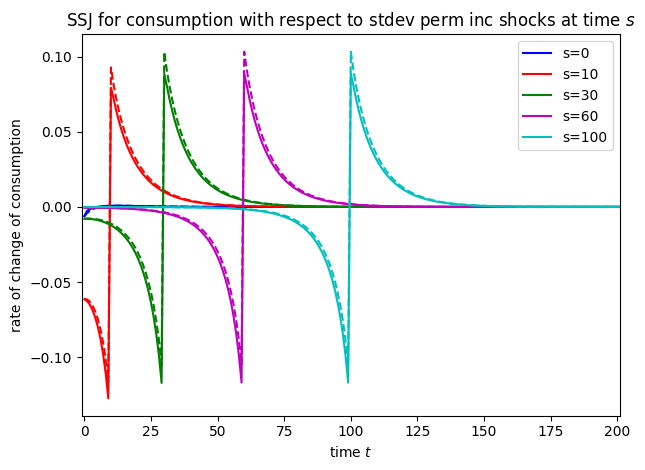

In [8]:
plot_SSJ(
    [SSJ_C_sigma_psi, CJAC_Perm],
    S_set,
    "consumption",
    "stdev perm inc shocks",
    T_max=200,
)

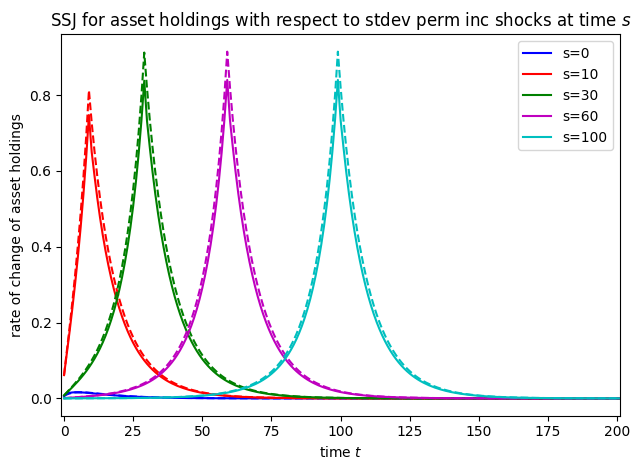

In [9]:
plot_SSJ(
    [SSJ_A_sigma_psi, AJAC_Perm],
    S_set,
    "asset holdings",
    "stdev perm inc shocks",
    T_max=200,
)

### Shock to Real Interest Rate

In [10]:
# Compute Jacobian using old method
start = time()
CJAC_Rfree, AJAC_Rfree = Agent.calc_jacobian("Rfree", 300)
print("Seconds to calculate Jacobian by old method: {:.3f}".format(time() - start))

Seconds to calculate Jacobian by old method: 4.666


#### Do the same thing with the new version and compare them

In [11]:
# Compute the SSJs and time it
t0 = time()
SSJ_A_r, SSJ_C_r = AltAgent.make_basic_SSJ(
    "Rfree",
    ["aNrm", "cNrm"],
    my_grid_specs,
    norm="PermShk",
    offset=True,
    solved=True,
)
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

Constructing those SSJs took 6.091 seconds in total.


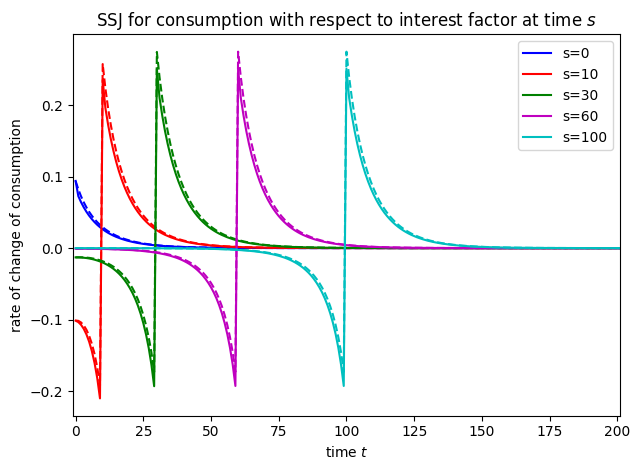

In [12]:
plot_SSJ([SSJ_C_r, CJAC_Rfree], S_set, "consumption", "interest factor", T_max=200)

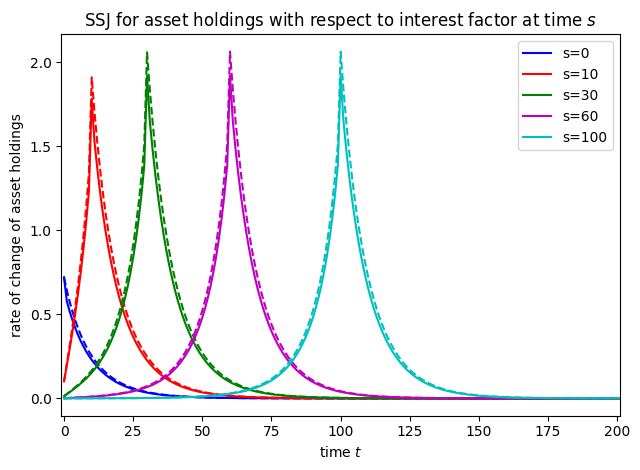

In [13]:
plot_SSJ([SSJ_A_r, AJAC_Rfree], S_set, "asset holdings", "interest factor", T_max=200)

### Shock to Unemployment Probability

In [14]:
# Make SSJs using old method
start = time()
CJAC_UnempPrb, AJAC_UnempPrb = Agent.calc_jacobian("UnempPrb", 300)
print("Seconds to calculate Jacobian by old method: {:.3f}".format(time() - start))

Seconds to calculate Jacobian by old method: 4.851


#### Do the same thing with the new version and compare them

In [15]:
# Compute the SSJs and time it
t0 = time()
SSJ_A_U, SSJ_C_U = AltAgent.make_basic_SSJ(
    "UnempPrb",
    ["aNrm", "cNrm"],
    my_grid_specs,
    norm="PermShk",
    offset=True,
    solved=True,
)
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

Constructing those SSJs took 6.152 seconds in total.


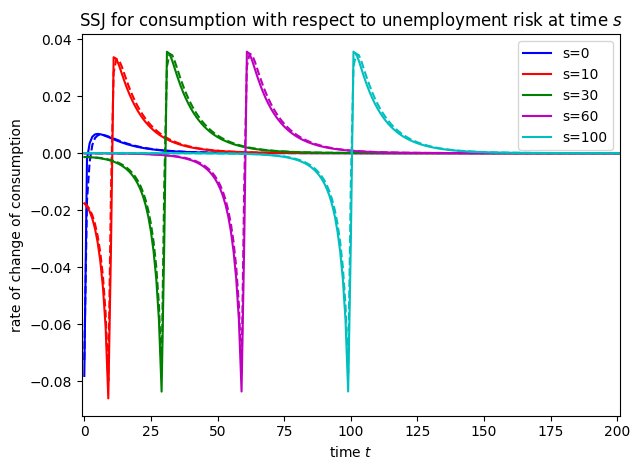

In [16]:
plot_SSJ([SSJ_C_U, CJAC_UnempPrb], S_set, "consumption", "unemployment risk", T_max=200)

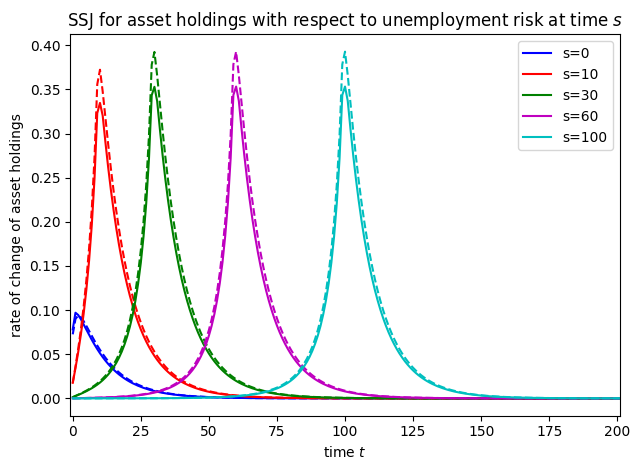

In [17]:
plot_SSJ(
    [SSJ_A_U, AJAC_UnempPrb], S_set, "asset holdings", "unemployment risk", T_max=200
)